In [1]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import os

Reference Notebooks:
1. [Titanic Data Science Solutions](https://www.kaggle.com/code/startupsci/titanic-data-science-solutions) by [Manav Sehgal](https://www.kaggle.com/startupsci)
2. [Titanic Project Example](https://www.kaggle.com/code/kenjee/titanic-project-example/notebook) by [KenJee](https://www.kaggle.com/kenjee)
3. [A Guide to Handling Missing values in Python](https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python) by [Parul Pandey](https://www.kaggle.com/parulpandey). Notebook referenced in Kaggle Book (Chapter on "Modeling for Tabular Competitions").
4. [Titanic: Keras + KerasTuner best practices](https://www.kaggle.com/code/fchollet/titanic-keras-kerastuner-best-practices/notebook) by [fchollet](https://www.kaggle.com/fchollet). Notebook referenced in Kaggle Book (Chapter on "Hyperparameter optimization").
5. [Titanic Tutorial](https://www.kaggle.com/code/alexisbcook/titanic-tutorial/notebook) by [Alexis Cook](https://www.kaggle.com/alexisbcook)
6. [An Interactive Data Science Tutorial](https://www.kaggle.com/code/helgejo/an-interactive-data-science-tutorial) by [Helgejo](https://www.kaggle.com/code/helgejo/an-interactive-data-science-tutorial)
7. [Hands-on Machine Learning: Classification](https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb) by [Aurélien Geron](https://github.com/ageron)

# Problem definition and understanding

The [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic) problem is described as follows: We shall build a predictive machine learning model that answers the question: "what sorts of people were more likely to survive?", using passenger data like name, age, gender, socio-economic class, etc. We are working with 1309 observations of 12 variables. The data has been split into two groups: a training set (train.csv) and a test set (test.csv). For the training set the outcome ("ground truth") for each passenger is provided. It is your job to predict these outcomes for the test set.

## Variable Description

- PassengerId: a unique identifier for each passengerPassengerId: a unique identifier for each passenger
- Survived: Survived (1) or died (0)
- Pclass: Passenger's class
- Name: Passenger's name
- Sex: Passenger's sex
- Age: Passenger's age
- SibSp: Number of siblings/spouses aboard
- Parch: Number of parents/children aboard
- Ticket: Ticket number
- Fare: Fare
- Cabin: Cabin
- Embarked: Port of embarkation

# Data analysis

In [2]:
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

In [3]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Examine target column
df_train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

The **target** is categorical / binary: `Survived`. Around 38 % of the samples in the training set have survived = 1, which is a little more than the actual survival rate of 32 %. 

The 891 samples of the training set make up 40 % of the actual number of passengers on the Titanic, which is 2224. In the info-table below we can already see what could be numerical and categorial features. 

The **numerical** features are:
* Continous (float64): `Age` (in years), `Fare` (= passenger fare)
* Discrete (int64): `SibSp` (= number of siblings / spouses aboard the Titanic), `Parch` (= number of PARents / CHildren aboard the Titanic)

And as **categorical** features:
* Categorical: `Sex` and `Embarked` (Port of Embarkation). 
* Ordinal: `Pclass`.

## Missing values

We want to look for missing values and, most importantly, missing value patterns correlated with the target.

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Numeric variables distribution

We want to look for skewed numeric variables and their possible transformations. The **numerical** features are:
* Continous (float64): `Age` (in years), `Fare` (= passenger fare)
* Discrete (int64): `PassengerId`, `SibSp` (= number of siblings / spouses aboard the Titanic), `Parch` (= number of PARents / CHildren aboard the Titanic)

In [7]:
# look at numeric and categorical values separately 
df_num = df_train[['Age','SibSp','Parch','Fare']]

In [8]:
df_num.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


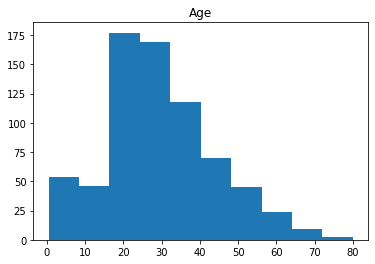

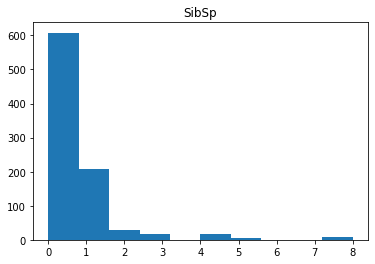

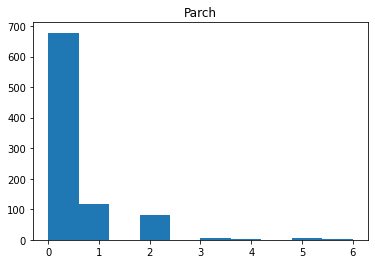

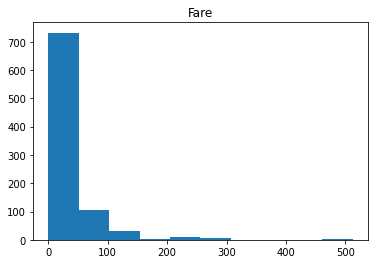

In [9]:
# plot histograms
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

Observations about the numerical features:

* `PassengerId` does not contribute to survival. We have already set it as an index for our DataFrame.
* `Age` We have mostly young people between 20 and 30. Few elderly passengers (<1%) within age range 65-80! Since it has about 19% missing values, we might want to **complete the feature** (perhaps with median age). Also age bands could be relevant as a **new feature** (ordinal categorical instead of numerical).
* `SibSp` Nearly 30% of the passengers had siblings and/or spouse aboard.
* `Parch` Most passengers (> 75%) did not travel with parents or children. We could think of the total count of family members on board (`SibSp`+`Parch`) as a **new feature**.
* `Fare` varies significantly with few passengers (<1%) paying as high as 512 Dollars. We may also want to create a Fare range **new feature** if it helps our analysis.

Looking at the histograms, KenJee considers normalizing the relevant features. But we'll come back to that later.

## Categorical features distribution

Further look for: Rare categories in categorical variables that can be grouped together; Potential outliers, both univariate and multivariate.

And as **categorical** features:
* Categorical: `Survived` (the target variable: 0 or 1), `Sex` and `Embarked` (Port of Embarkation). 
* Ordinal: `Pclass`.



In [10]:
df_cat = df_train[['Survived','Pclass','Name','Sex','Ticket','Cabin','Embarked']]
df_cat.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


Observations:
* `Name` will probably not influence the survival and is also completely unique across the dataset, so can be dropped. The titles might be relevant as a **new feature**, though.
* `Sex` variable has two possible values with 65% male (577 of 891).
* `Ticket` may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival. (But it could be.)
* `Cabin` values have several dupicates across samples. Alternatively several passengers shared a cabin. Referring to Malav, it can be dropped as it is highly incomplete or contains many null values both in training and test dataset. KenJee creates categories based on the cabin letter.
* `Embarked` takes three possible values. Most passengers have embarked from "S". Since it has missing values, we might want to **complete the feature**.


## Correlations

Look for: Highly correlated (or even duplicated) features. For categorical variables, focus on categories that overlap. The most predictive features for the problem.

In [11]:
# pivot table for numerical features
pd.pivot_table(df_train, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


`Age`: Children were more likely to have survived. 

Lets have a look at our categorical variables, too. Here we use separate correlation tables for each variable:

In [12]:
# Correlation of "Pclass" with "Survived"
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


We can see the correlation between Pclass = 1 and Survived is quite high, over 62 %. This feature should definitely be **included** in our model.

In [13]:
# Correlation of "Sex" with "Survived"
df_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)



,Sex,Survived
0,female,0.742038
1,male,0.188908


With over 74 % the survival rate for Sex = female is significantly higher than for male. We should **include** this, too. 

In [14]:
# Correleation of "SibSp" with "Survived"
df_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


As we said before, the "SibSp" and "Parch" columns may be used to create some **new feature**. (But why not separate?)

In [15]:
# Correleation of "Parch" with "Survived"
df_train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


# Data preprocessing

In this version of the Notebook we build two preprocessing pipelines, one for numerical features and one for categorical, which are then joined together. But first we create some new features, as mentioned before:

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [17]:
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [18]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

# Modeling

Now that we have a preprocessing pipeline that takes the raw data and outputs numerical input features, we can feed to a Machine Learning model. We're using a cross-validation strategy for model validation.

In [19]:
X_train = preprocess_pipeline.fit_transform(
    df_train[num_attribs + cat_attribs])
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [20]:
y_train = df_train["Survived"]

We are now ready to train a classifier.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

# forest_clf.fit(X_train, y_train)

0.8092759051186016

In [22]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

The SVC performs a little better, so we choose it for prediction.

In [23]:
# Fit the model
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [24]:
# Make predictions
X_test = preprocess_pipeline.transform(df_test[num_attribs + cat_attribs])
y_pred = svm_clf.predict(X_test).astype(int)

# Submission

In [25]:
passenger_id = df_test.PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': y_pred } )
test.Survived.astype('int')
test.dtypes

PassengerId    int64
Survived       int64
dtype: object

In [26]:
# test.to_csv( 'titanic_forest_clf.csv', index = False )
test.to_csv( 'titanic_svm_clf.csv', index = False )
print("Submission was successfully saved!")

Submission was successfully saved!
